In [1]:
import networkx as nx
import numpy as np
import torch
import torch_geometric.utils as pyg_utils
import matplotlib.pyplot as plt

import torch_geometric.utils as pyg_utils
from torch_geometric.datasets import TUDataset, KarateClub

import sklearn

In [2]:
"""
Frederik's plotting of Bandpass filtering.
Currenty not used to produce figures in the paper, for that
see `plot_individual_perturbations` in generate_perturbation_plots.py
"""

"\nFrederik's plotting of Bandpass filtering.\nCurrenty not used to produce figures in the paper, for that\nsee `plot_individual_perturbations` in generate_perturbation_plots.py\n"

In [3]:
def f(data, band):
    num_nodes = data.num_nodes

    # Prepare the (undirected, unweighted, no self loop) graph Laplacian
    G = pyg_utils.to_networkx(
        data,
        to_undirected=False,  # This conversion option is buggy (PyG 2.0.2); do not use.
        remove_self_loops=True,
    ).to_undirected()
    
    L = nx.normalized_laplacian_matrix(G, weight=None).toarray()
    
    lams, evects = np.linalg.eigh(L)  # Use eigh to enforce ortho eigvecs.

    i = ['lo', 'mid', 'hi'].index(band)
    num_evect = num_nodes // 3
    start_idx = i * num_evect
    end_idx = start_idx + num_evect if i < 2 else num_nodes
    evect_slice = slice(start_idx, end_idx)

    selected_idx = lams.argsort()[evect_slice]
    evects = torch.from_numpy(evects[:, selected_idx].astype('float32'))
    lams = lams[selected_idx]
    
    x_hat = torch.matmul(evects.T, data.x)
    
    return torch.matmul(evects, x_hat)


In [4]:
dataset = TUDataset(root='/tmp/ENZYMES', name='ENZYMES', use_node_attr=True)
sample = 0 # [0, 20, 40, 50]
# sample = 50
data = dataset[sample]

In [5]:
k=9
# k=6
# 6, 7
# 3, 6


y = data.x[:,k]
y_low = f(data,'lo')[:,k]
y_mid = f(data,'mid')[:,k]
y_high = f(data,'hi')[:,k]

vals = torch.cat((y, y_low, y_mid, y_high), 0)
vmin, vmax = vals.min(), vals.max()

G = pyg_utils.to_networkx(data, to_undirected=True)
pos = nx.kamada_kawai_layout(G)
cmap = plt.cm.coolwarm

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])

node_size = 200

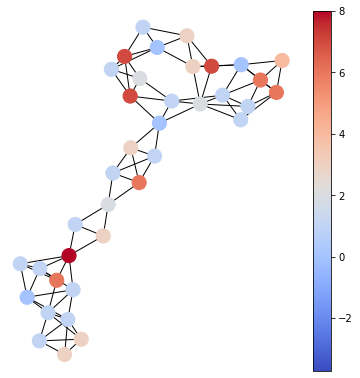

In [6]:
fig = plt.figure(figsize=(5,5))
nx.draw(G, pos, node_size=node_size, node_color=y, cmap=cmap, vmin=vmin, vmax=vmax)
cbar = plt.colorbar(sm)
plt.savefig('original.pdf')

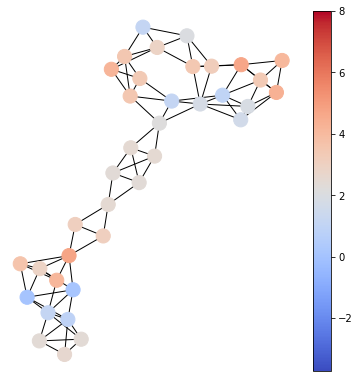

In [7]:
fig = plt.figure(figsize=(5,5))
nx.draw(G, pos, node_size=node_size, node_color=y_low, cmap=cmap, vmin=vmin, vmax=vmax)
cbar = plt.colorbar(sm)
plt.savefig('low.pdf')

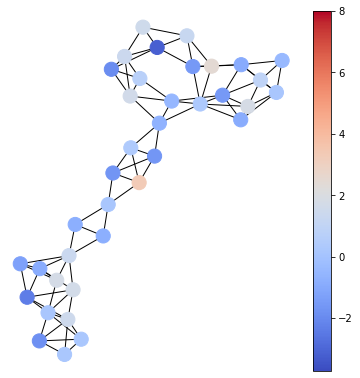

In [8]:
fig = plt.figure(figsize=(5,5))
nx.draw(G, pos, node_size=node_size, node_color=y_mid, cmap=cmap, vmin=vmin, vmax=vmax)
cbar = plt.colorbar(sm)
plt.savefig('mid.pdf')

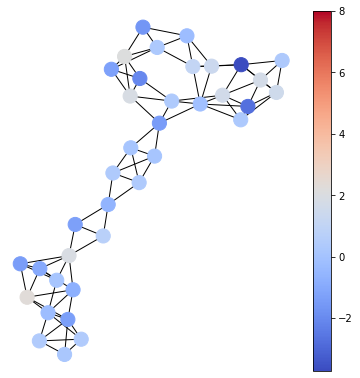

In [9]:
fig = plt.figure(figsize=(5,5))
nx.draw(G, pos, node_size=node_size, node_color=y_high, cmap=cmap, vmin=vmin, vmax=vmax)
cbar = plt.colorbar(sm)
plt.savefig('high.pdf')